<a href="https://colab.research.google.com/github/vshalisko/GEE/blob/main/AUEM/Taller_20241219/ESE_preprocesamiento_L8_tres_fechas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ensayo 2024.12.19
## Ensenada
### Visuzlización de zona de estudio en Colab - GEE
### Vesión con el proceso de generar mosaico para combinar imagenes de varias zonas y/o para eliminar nubes
### Tres fechas de Landsat 8: 2014, 2015, 2020
### Descarga y guardado de Numpy arrays y GeoTIFF de imagen L8 y datos de referencias


In [21]:
## Definir variables

## Prefilo de zona
prefijo = "ESE"

## Ruta en Google Drive (se requiere crear una carpeta en raíz de Google Drive)
ruta = "Colab Data"

## Punto de centro de zona en coordenadas geográficas
punto_interes_text = [-116.6064, 31.8680]

## Proyeccion UTM aplicable
projection_text = "EPSG:32611"

## limites de rectangulo de zona de estudio en UTM
#limites_utm = [531951, 547066, 3513217, 3532728]    # versión agosto 2024
limites_utm = [523989, 548709, 3502560, 3532709]

## tamaño de pixel
pixel = 30

## número de pixeles máximo en segmento
## Nota: GEE generará error en caso que este numero es mayor que 262144
max_tile = 200000

## fechas para imagenes de satelite
#inicio_2015 = "2015-03-01"
#final_2015 = "2015-06-30"

## datos para definición de rango de fechas imagenes de satelite
## rango de meses
m_inicio = 3
m_final = 6
## rangos de años
y_inicio_2014 = 2014
y_final_2014 = 2014
y_inicio_2015 = 2015
y_final_2015 = 2015
y_inicio_2020 = 2020
y_final_2020 = 2020

## porcentaje máximo de nubes permitido
nubes = 4

## bandas de L8 utiles
bands_L8 = ['SR_B2','SR_B3','SR_B4','SR_B5','SR_B6','SR_B7']

## bandas de capa de referencia
bands_B = ['settlement']


#### Praparar el entorno

In [2]:
## cargar bibliotecas GEE y GEEmap
import ee
import geemap
from google.colab import drive
import math
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal, osr


# Iniciar autentificacion
ee.Authenticate()

# Inicializar proyecto GEE
ee.Initialize(project='ee-vshalisko')

## Inicializar Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Preparar datos para GEE

In [3]:
punto_interes = ee.Geometry.Point(punto_interes_text)

projection = ee.Projection(projection_text)

bbox = ee.Geometry.Rectangle([limites_utm[0], limites_utm[2], limites_utm[1], limites_utm[3]], projection, True, False)

#### Definir funciones auxiliares para descarga de la imagen, control de nubes y calidad de pixeles



In [15]:
## funcion para eliminar nubes y sombras
def maskClouds(image):
    qa = image.select('QA_PIXEL')
    cloud_shadow_bit_mask = (1 << 3)
    cloud_bit_mask = (1 << 4)
    cloud_mask = qa.bitwiseAnd(cloud_shadow_bit_mask).eq(0).And(qa.bitwiseAnd(cloud_bit_mask).eq(0))
    return image.updateMask(cloud_mask)

def descarga_imagen_L8(m_inicio, m_final, y_inicio, y_final, nubes):
  print('\nSelección de la imagen', y_inicio)
  ## Ejemplo de coleccion con presencia de nubes
  L8_collection = (ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
                      .filterBounds(punto_interes)
                      .filter(ee.Filter.calendarRange(m_inicio,m_final, "month"))
                      .filter(ee.Filter.calendarRange(y_inicio, y_final, "year"))
                      .filter(ee.Filter.lessThan("CLOUD_COVER", nubes)))
  print('Capas de datos filtrados', y_inicio, '-', y_final, ':', L8_collection.size().getInfo())

  # Cargar primer imagen de la colección
  L8_image = L8_collection.first()
  image_meta = L8_image.getInfo()
  imagename = image_meta.get('properties',{}).get('LANDSAT_PRODUCT_ID')
  print('Imagen base elegido:', imagename)

  ## obtener lista de nombres de bandas
  bands_original_names = L8_image.bandNames();

  ## Extraer datos de proyeccion de la imagen L8
  projection = L8_image.projection().getInfo();

  ## Consultar datos de la proyección
  print('Proyeccion:', projection.get('crs'))
  print('Transformación lineal:', projection.get('transform'))

  ## generar el mosaico
  L8_image_mosaic = L8_collection.map(maskClouds).reduce(ee.Reducer.mean())

  ## renombrar bandas al esquema original
  L8_image_mosaic = L8_image_mosaic.rename(bands_original_names)

  ## asignar proyeccion al mosaico
  L8_image_re = L8_image_mosaic.reproject(projection.get('crs'), projection.get('transform'), None)

  return L8_image_re

Seleccionar imagenes Landsat 8 para los años 2014, 2015 y 2020

In [22]:
L8_image_2015_re = descarga_imagen_L8(m_inicio, m_final, y_inicio_2015, y_final_2015, nubes)
L8_image_2014_re = descarga_imagen_L8(m_inicio, m_final, y_inicio_2014, y_final_2014, nubes)
L8_image_2020_re = descarga_imagen_L8(m_inicio, m_final, y_inicio_2020, y_final_2020, nubes)


Selección de la imagen 2015
Capas de datos filtrados 2015 - 2015 : 2
Imagen base elegido: LC08_L2SP_039038_20150606_20200909_02_T1
Proyeccion: EPSG:32611
Transformación lineal: [30, 0, 479985, 0, -30, 3628215]

Selección de la imagen 2014
Capas de datos filtrados 2014 - 2014 : 5
Imagen base elegido: LC08_L2SP_039038_20140315_20200912_02_T1
Proyeccion: EPSG:32611
Transformación lineal: [30, 0, 477285, 0, -30, 3628215]

Selección de la imagen 2020
Capas de datos filtrados 2020 - 2020 : 2
Imagen base elegido: LC08_L2SP_039038_20200502_20200820_02_T1
Proyeccion: EPSG:32611
Transformación lineal: [30, 0, 476685, 0, -30, 3628215]


#### Cargar y preparar datos categoricos para 2015

In [19]:
# Cargar builtup 2015 (res 10 m) y reclasificar a 0 y 1
built_2015_hr = ee.Image('DLR/WSF/WSF2015/v1')
built_2015_hr = built_2015_hr.where(built_2015_hr.eq(255), 1)

# Cargar cuerpor de agua (res 30)
elev_dataset = ee.ImageCollection('COPERNICUS/DEM/GLO30').filterBounds(L8_image_2015.geometry())
print('Segmentos WBM filtrados:', elev_dataset.size().getInfo())
MDE_Copernicus_proj = elev_dataset.first().projection()
water_mosaico = elev_dataset.select('WBM').mosaic()
water_mosaico = water_mosaico.setDefaultProjection(MDE_Copernicus_proj)
water_binary = water_mosaico.gt(0)

## Datos categoricas deben quedar en misma proyección de Landsat 8, con mismo tamaño y resolución
## Reproyectar layers
built_2015_hr_reprojected = built_2015_hr.reproject(projection.get('crs'), projection.get('transform'))
water_binary_reprojected = water_binary.reproject(projection.get('crs'), projection.get('transform'))

## Combinar capas de builtup y agua en una capa categorica de tres clases (0 - no-urbano, 1 - agua, 2 - urbano)
built_2015_agua_hr_reprojected = built_2015_hr_reprojected.unmask(0)
built_2015_agua_hr_reprojected = (built_2015_agua_hr_reprojected.where(built_2015_agua_hr_reprojected.eq(1), 2))
built_2015_agua_hr_reprojected = (built_2015_agua_hr_reprojected.where(water_binary_reprojected.eq(1), 1))

## renombrar capa resultante
built_2015_hr_reprojected = built_2015_hr_reprojected.rename(bands_B)

## renombrar capa resultante
#built_2015_agua_hr_reprojected = built_2015_agua_hr_reprojected.rename(bands_B).setDefaultProjection(L8_image_2015.projection())
built_2015_agua_hr_reprojected = built_2015_agua_hr_reprojected.rename(bands_B)
print(built_2015_agua_hr_reprojected.getInfo())

Segmentos WBM filtrados: 8
{'type': 'Image', 'bands': [{'id': 'settlement', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 255}, 'crs': 'EPSG:32611', 'crs_transform': [30, 0, 480585, 0, -30, 3628215]}], 'version': 1728918335381151, 'id': 'DLR/WSF/WSF2015/v1', 'properties': {'system:footprint': {'type': 'LinearRing', 'coordinates': [[-180, -90], [180, -90], [180, 90], [-180, 90], [-180, -90]]}, 'system:asset_size': 6718369799}}


#### Visualizar datos en GEE

In [23]:
## Parametros de visualizacion del poligono
visPol = {
  'color': '0000FF',
  'width': 2,
  'opacity': 0.25
};

## Parametros de visualizacion para Landsat 8
vizParams_L8 = {
  'bands': ['SR_B5', 'SR_B4', 'SR_B3'],
   'min': 5000,
   'max': 15000
}

## Parametros de visualizacion para capa categorica
vizBuiltupAgua = {
   'min': 0,
   'max': 2,
  'palette': ['beige', 'blue', 'black']
}

## definir ventana de mapa
map = geemap.Map()

## Centrar
map.centerObject(punto_interes, 10)


## Agregar capas de datos al mapa
map.addLayer(L8_image_2014_re, vizParams_L8, '2014 mosaic FC', False, 0.5)
map.addLayer(L8_image_2015_re, vizParams_L8, '2015 mosaic FC', True, 0.5)
map.addLayer(L8_image_2020_re, vizParams_L8, '2020 mosaic FC', False, 0.5)
map.addLayer(built_2015_agua_hr_reprojected, vizBuiltupAgua, 'referencia categorica', True, 0.5)
map.addLayer(bbox, visPol, "Area de estudio", True, 1)
map.addLayer(punto_interes, {}, "Punto de centro", True, 1)


## Presentar el mapa
map

Map(center=[31.868000000000002, -116.6064], controls=(WidgetControl(options=['position', 'transparent_bg'], wi…

#### Definición de los segmentos para descarga y conversión de datos desde GEE a numpy

In [24]:
def segmentation(limits, pixel_size, max_tile_size, proj):
  alto_px = math.ceil((limits[3] - limits[2]) / pixel_size)
  ## alto en pixeles
  print('Alto del segmento (pixeles)', alto_px)
  ## ancho estandar de segmento en pixeles
  ancho_px = math.ceil(max_tile_size / alto_px)
  print('Ancho del segmento (pixeles)', ancho_px)
  ## ancho astandar de segmento en unidades de proyeccion
  incremento = ancho_px * pixel_size
  print('Ancho del segmento (unidades de proyeccion)', incremento)
  ## lista de los límites x de segmentos
  seq = list(np.arange(limits[0], limits[1], incremento))
  seq.append(limites_utm[1])
  print('Secuencia de marcas de longitud para los segmentos')
  print(seq)

  ## definición de las geometrias rectangulares de segmentos
  segments = []
  for i in range(len(seq)-1):
    #print(seq[i], seq[i+1])
    segment = ee.Geometry.Rectangle([int(seq[i]), limites_utm[2], int(seq[i+1]), limites_utm[3]], proj, True, False)
    #print(segment)
    segments.append(segment)

  return segments

## llamar funcion que genera geometrias de segmentos
segment_list = segmentation(limites_utm, pixel, max_tile, projection_text)

## Agregar capas de datos al mapa 1
map1 = geemap.Map()
map1.centerObject(punto_interes, 10)
map1.addLayer(bbox, {}, 'Area de estudio', False, 0.5)

for i in range(len(segment_list)):
  segment_name = "segment " + str(i)
  map1.addLayer(segment_list[i], {}, segment_name, True, 0.3)

## Presentar el mapa
map1

Alto del segmento (pixeles) 1005
Ancho del segmento (pixeles) 200
Ancho del segmento (unidades de proyeccion) 6000
Secuencia de marcas de longitud para los segmentos
[523989, 529989, 535989, 541989, 547989, 548709]


Map(center=[31.868000000000002, -116.6064], controls=(WidgetControl(options=['position', 'transparent_bg'], wi…

#### Funciones para descarga y conversión de datos GEE

In [25]:
def tile_to_numpy(image, rectangle, bands):
  ## extraccion de bandas en un region rectangular
  image_tile = image.sampleRectangle(region=rectangle,defaultValue=0)
  first_band = image_tile.get(bands[0])
  band_array_np = np.array(first_band.getInfo())
  band_array_np = np.expand_dims(band_array_np, 2)
  for b in bands[1:]:
    b_arr = image_tile.get(b)
    b_arr_np = np.array(b_arr.getInfo())
    b_arr_np = np.expand_dims(b_arr_np, 2)
    #print(band_array_np.shape)
    #print(b_arr_np.shape)
    band_array_np = np.concatenate((band_array_np, b_arr_np), 2)
  return band_array_np

def merge_feature_array(image, segments, bands, correction=True):
  ## combinaccion de segmentos
  array_feature = tile_to_numpy(image, segments[0], bands)
  if correction:
    ## elimina linea de pixeles que sobra en la parte derecha e inferior
    array_feature = array_feature[:array_feature.shape[0]-1,:array_feature.shape[1]-1,:]
  print("New feature array", array_feature.shape)
  for segment in segments[1:]:
    feature_segment = tile_to_numpy(image, segment, bands)
    if correction:
      ## elimina linea de pixeles que sobra en la parte derecha e inferior
      feature_segment = feature_segment[:feature_segment.shape[0]-1,:feature_segment.shape[1]-1,:]
    print("Feature segment", feature_segment.shape)
    array_feature = np.concatenate((array_feature, feature_segment), 1)
  print("Full new feature array", array_feature.shape)
  return array_feature

#### Descarga Landsat 8 para 2015

New feature array (1005, 200, 6)
Feature segment (1005, 200, 6)
Feature segment (1005, 200, 6)
Feature segment (1005, 200, 6)
Feature segment (1005, 24, 6)
Full new feature array (1005, 824, 6)


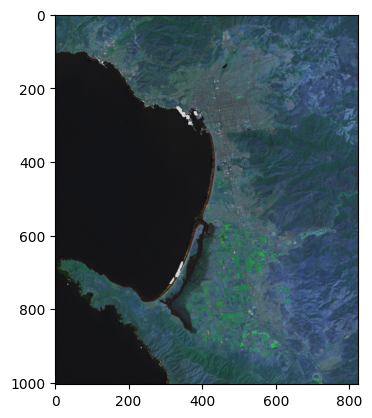

In [26]:
array_feature_2015 = merge_feature_array(L8_image_2015_re, segment_list, bands_L8)

# Reescalar datos a rango [0, 255] y representar como imagen RGB
rgb_img_new = (255*((array_feature_2015 - 5000)/30000)).astype('uint8')
plt.imshow(rgb_img_new[:,:,2:5])
plt.show()

#### Descarga Landsat 8 para 2014

New feature array (1005, 200, 6)
Feature segment (1005, 200, 6)
Feature segment (1005, 200, 6)
Feature segment (1005, 200, 6)
Feature segment (1005, 24, 6)
Full new feature array (1005, 824, 6)


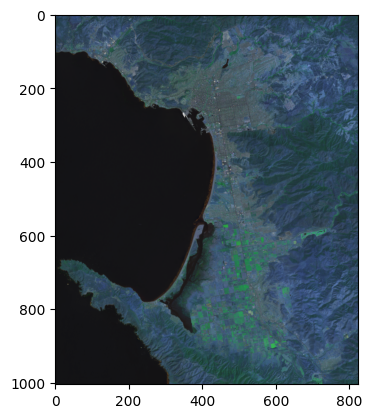

In [27]:
array_feature_2014 = merge_feature_array(L8_image_2014_re, segment_list, bands_L8)

# Reescalar datos a rango [0, 255] y representar como imagen RGB
rgb_img_new = (255*((array_feature_2014 - 5000)/30000)).astype('uint8')
plt.imshow(rgb_img_new[:,:,2:5])
plt.show()

#### Descarga Landsat 8 para 2020

New feature array (1005, 200, 6)
Feature segment (1005, 200, 6)
Feature segment (1005, 200, 6)
Feature segment (1005, 200, 6)
Feature segment (1005, 24, 6)
Full new feature array (1005, 824, 6)


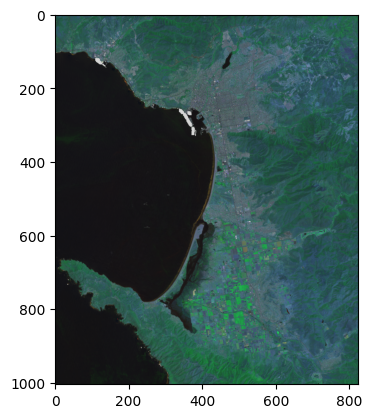

In [28]:
array_feature_2020 = merge_feature_array(L8_image_2020_re, segment_list, bands_L8)

# Reescalar datos a rango [0, 255] y representar como imagen RGB
rgb_img_new = (255*((array_feature_2020 - 5000)/30000)).astype('uint8')
plt.imshow(rgb_img_new[:,:,2:5])
plt.show()

Descarga datos categoricos 2015

New feature array (1005, 200, 1)
Feature segment (1005, 200, 1)
Feature segment (1005, 200, 1)
Feature segment (1005, 200, 1)
Feature segment (1005, 24, 1)
Full new feature array (1005, 824, 1)


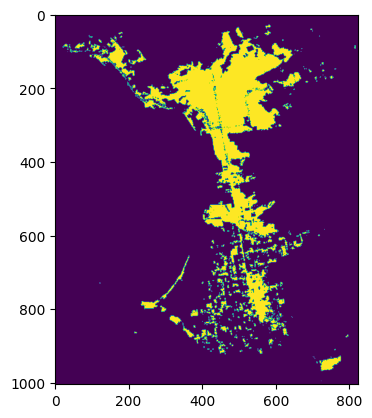

Valores únicos de clases [0 1]
Conteo de pixeles de valores únicos [727222 100898]
New feature array (1005, 200, 1)
Feature segment (1005, 200, 1)
Feature segment (1005, 200, 1)
Feature segment (1005, 200, 1)
Feature segment (1005, 24, 1)
Full new feature array (1005, 824, 1)


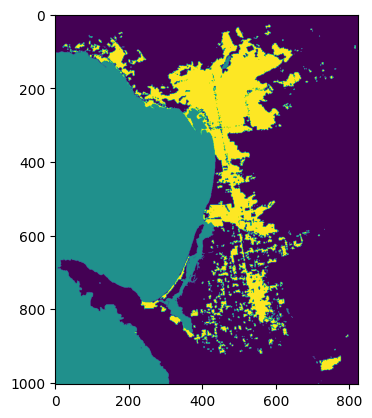

Valores únicos de clases [0 1 2]
Conteo de pixeles de valores únicos [447960 280173  99987]


In [29]:
## Variante de capa binaria
array_target_binary_2015 = merge_feature_array(built_2015_hr_reprojected, segment_list, bands_B)

## Reescalar datos a rango [0, 255] y representar como imagen RGB
rgb_img_new = (array_target_binary_2015).astype('uint8')
plt.imshow(rgb_img_new[:,:,0])
plt.show()

unique_values_bin, occurrence_count_bin = np.unique(array_target_binary_2015, return_counts=True)
print('Valores únicos de clases', unique_values_bin)
print('Conteo de pixeles de valores únicos', occurrence_count_bin)

## Variante de capa de tres clases
array_target_2015 = merge_feature_array(built_2015_agua_hr_reprojected, segment_list, bands_B)

## Reescalar datos a rango [0, 255] y representar como imagen RGB
rgb_img_new = (array_target_2015).astype('uint8')
plt.imshow(rgb_img_new[:,:,0])
plt.show()

unique_values, occurrence_count = np.unique(array_target_2015, return_counts=True)
print('Valores únicos de clases', unique_values)
print('Conteo de pixeles de valores únicos', occurrence_count)

#### Guardar datos en numpy arrays en Google Drive

In [33]:
ruta_L8_2014 = "/content/drive/MyDrive/" + ruta + "/" + prefijo + "_2014_feature_L8_6b.npy"
print(ruta_L8_2014)

ruta_L8_2015 = "/content/drive/MyDrive/" + ruta + "/" + prefijo + "_2015_feature_L8_6b.npy"
print(ruta_L8_2015)

ruta_L8_2020 = "/content/drive/MyDrive/" + ruta + "/" + prefijo + "_2020_feature_L8_6b.npy"
print(ruta_L8_2020)

ruta_target_2015 = "/content/drive/MyDrive/" + ruta + "/" + prefijo + "_2015_target.npy"
print(ruta_target_2015)

ruta_target_binary_2015 = "/content/drive/MyDrive/" + ruta + "/" + prefijo + "_2015_target_binary.npy"
print(ruta_target_binary_2015)

np.save(ruta_L8_2014, array_feature_2014)
np.save(ruta_L8_2015, array_feature_2015)
np.save(ruta_L8_2020, array_feature_2020)
np.save(ruta_target_2015, array_target_2015)
np.save(ruta_target_binary_2015, array_target_binary_2015)

/content/drive/MyDrive/Colab Data/ESE_2014_feature_L8_6b.npy
/content/drive/MyDrive/Colab Data/ESE_2015_feature_L8_6b.npy
/content/drive/MyDrive/Colab Data/ESE_2020_feature_L8_6b.npy
/content/drive/MyDrive/Colab Data/ESE_2015_target.npy
/content/drive/MyDrive/Colab Data/ESE_2015_target_binary.npy


#### Preparar guardado de datos en GeoTIFF

In [31]:
def write_geotiff(arr, filename, proj, transform):
    n_bands = arr.shape[2]
    if arr.dtype == np.float32:
        arr_type = gdal.GDT_Float32
    else:
        arr_type = gdal.GDT_Int32
    driver = gdal.GetDriverByName("GTiff")
    out_ds = driver.Create(filename, arr.shape[1], arr.shape[0], n_bands, arr_type)
    out_ds.SetProjection(proj)
    out_ds.SetGeoTransform(transform)
    for band in range(n_bands):
      #print(band)
      arr_data = arr[:,:,band]
      #print(arr_data)
      band = out_ds.GetRasterBand(band + 1)
      band.WriteArray(arr_data)
      band.FlushCache()
      band.ComputeStatistics(False)


sr = osr.SpatialReference()
sr.ImportFromEPSG(int(projection_text.replace(projection_text[:5], '')))


## Nota: todos arrays deben ser de mismo número de pixeles de ancho y alto
## y no se recalcularlo para cada capa, solo se calcula para target 2015

ancho_px_esperado = math.ceil((limites_utm[1] - limites_utm[0]) / pixel)
print('Ancho total esperado (pixeles)', ancho_px_esperado)
ancho_px_observado = array_target_2015.shape[1]
print('Ancho total observado (pixeles)', ancho_px_observado)
pixel_x = pixel * ancho_px_esperado / ancho_px_observado

alto_px_esperado = math.ceil((limites_utm[3] - limites_utm[2]) / pixel)
print('Alto total esperado (pixeles)', alto_px_esperado)
alto_px_observado = array_target_2015.shape[0]
print('Alto total observado (pixeles)', alto_px_observado)
pixel_y = pixel * alto_px_esperado / alto_px_observado

geotrans = [limites_utm[0], pixel_x, 0, limites_utm[3], 0, -pixel_y]

print(geotrans)
#print(sr)
print(sr.ExportToWkt())

Ancho total esperado (pixeles) 824
Ancho total observado (pixeles) 824
Alto total esperado (pixeles) 1005
Alto total observado (pixeles) 1005
[523989, 30.0, 0, 3532709, 0, -30.0]
PROJCS["WGS 84 / UTM zone 11N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32611"]]


In [34]:
ruta_L8_2014_tif = "/content/drive/MyDrive/" + ruta + "/" + prefijo + "_2014_feature_L8_6b.tif"
print(ruta_L8_2014_tif)

ruta_L8_2015_tif = "/content/drive/MyDrive/" + ruta + "/" + prefijo + "_2015_feature_L8_6b.tif"
print(ruta_L8_2015_tif)

ruta_L8_2020_tif = "/content/drive/MyDrive/" + ruta + "/" + prefijo + "_2020_feature_L8_6b.tif"
print(ruta_L8_2020_tif)

ruta_target_2015_tif = "/content/drive/MyDrive/" + ruta + "/" + prefijo + "_2015_target.tif"
print(ruta_target_2015_tif)

ruta_target_binary_2015_tif = "/content/drive/MyDrive/" + ruta + "/" + prefijo + "_2015_target_binary.tif"
print(ruta_target_binary_2015_tif)

write_geotiff(array_feature_2014[:,:,:], filename=ruta_L8_2014_tif, proj=sr.ExportToWkt(), transform=geotrans)
write_geotiff(array_feature_2015[:,:,:], filename=ruta_L8_2015_tif, proj=sr.ExportToWkt(), transform=geotrans)
write_geotiff(array_feature_2020[:,:,:], filename=ruta_L8_2020_tif, proj=sr.ExportToWkt(), transform=geotrans)
write_geotiff(array_target_2015[:,:,], filename=ruta_target_2015_tif, proj=sr.ExportToWkt(), transform=geotrans)
write_geotiff(array_target_binary_2015[:,:,], filename=ruta_target_binary_2015_tif, proj=sr.ExportToWkt(), transform=geotrans)


/content/drive/MyDrive/Colab Data/ESE_2014_feature_L8_6b.tif
/content/drive/MyDrive/Colab Data/ESE_2015_feature_L8_6b.tif
/content/drive/MyDrive/Colab Data/ESE_2020_feature_L8_6b.tif
/content/drive/MyDrive/Colab Data/ESE_2015_target.tif
/content/drive/MyDrive/Colab Data/ESE_2015_target_binary.tif
